In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Options

In [2]:
data_root = '../data/'
log_root = './logs/'
which_device = 'cpu'

In [3]:
myhost = os.uname()[1]
print('Hostname: ' + myhost)
if which_device == 'gpu' and torch.cuda.is_available():
    device_names = [torch.cuda.get_device_name(device=i) for i in range(torch.cuda.device_count())]
    tesla_idx = [dn.find('Tesla') for dn in device_names].index(0)
    device = torch.device("cuda:{}".format(tesla_idx))
print('Selected Device: ' + torch.cuda.get_device_name(torch.cuda.current_device()))

Hostname: D-01253-Arch
Selected Device: Tesla K20c


/home/drawitschf/.conda/envs/gen-EM/lib/python3.8/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


# Dataset

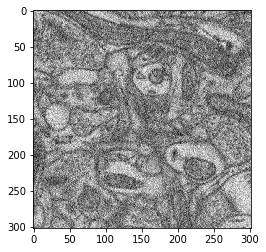

In [4]:
# Let's look at some data
img = plt.imread(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
plt.imshow(img, cmap='gray');

In [5]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [6]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = np.asarray(plt.imread(os.path.join(self.data_root, self.data_fnames[idx])))
        img = self._normalize(img)
        sample = SBEMCrop2dDataset._reshape_to_torch(img)
        return sample
    
    def _normalize(self, img):
        img = (np.asarray(img)-self.norm_params['mean'])/self.norm_params['std']
        return img
    
    @staticmethod
    def _reshape_to_torch(img):
        sample = torch.from_numpy(np.reshape(img, (1, img.shape[0], img.shape[1]))).float()
        return sample

## Instantiate dataset subclass

In [7]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)
len(sbem_dataset)

60

## Test dataset subclass

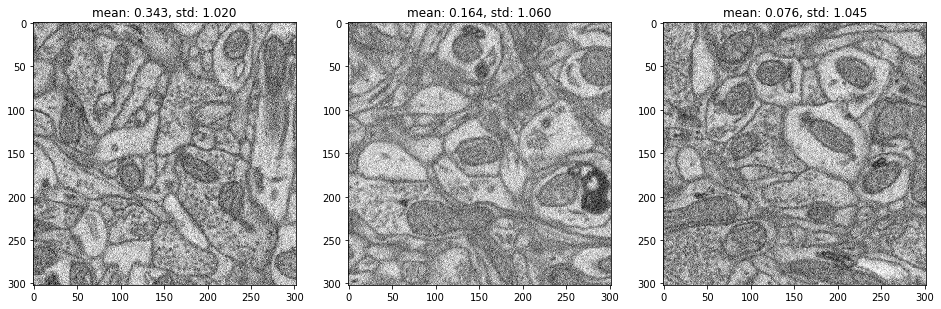

In [8]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    sample = sbem_dataset[i]
    img = sample.data.numpy().squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

# Model

## Define Model

In [9]:
def get_conv_pad(input_size, kernel_size, stride):
    padding = np.ceil(((stride-1)*input_size-stride+kernel_size)/2).astype(int)
    return padding

In [10]:
class Encoder_3_sampling(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(36**2*n_fmaps*4, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_fc(x.reshape((-1, 1, 36**2*n_fmaps*4)))
        
        return x

In [ ]:
class Encoder_3_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(36**2*n_fmaps*4, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_fc(x.reshape((-1, 1, 36**2*n_fmaps*4)))
        
        return x

In [12]:
class Encoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*4, n_fmaps*8, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(17**2*n_fmaps*8, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_conv4(x)
        x = self.encoding_fc(x.reshape((-1, 1, 17**2*n_fmaps*8)))
        
        return x

In [15]:
class Decoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, output_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.decoding_fc = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 17**2*n_fmaps*8),
            torch.nn.ReLU())
        
        self.decoding_convt1 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*8, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU())
        
        self.decoding_convt2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*4, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU())

        self.decoding_convt3 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*2, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU())
        
        self.decoding_convt4 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps, 1, kernel_size, stride))
        
    def forward(self, x):
        
        x = self.decoding_fc(x)
        x = self.decoding_convt1(x.reshape((-1, n_fmaps*8, 17, 17)))
        x = self.decoding_convt2(x)
        x = self.decoding_convt3(x)
        x = self.decoding_convt4(x)
        
        return x

In [16]:
class AE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Instantiate Model, Loss and Optimizer

In [17]:
input_size=302
output_size=input_size
valid_size = 17
input_center = int(np.floor(input_size/2))
valid_width = int(np.floor(valid_size/2))
kernel_size=3
stride=1
n_fmaps=8
n_latent=5000
net = AE(
    Encoder_4_sampling_bn(input_size, kernel_size, stride, n_fmaps, n_latent), 
    Decoder_4_sampling_bn(output_size, kernel_size, stride, n_fmaps, n_latent))
if which_device == 'gpu':
    net.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.8)

## Utility functions

In [18]:
def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    img_input = inputs[idx].data.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    img_output = outputs[idx].data.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

In [19]:
def crop_valid(tensor, center, width):
    valid_tensor = tensor[:, 0:1, center-width:center+width+1, center-width:center+width+1]
    return valid_tensor

# Train Model

In [20]:
trainloader = DataLoader(sbem_dataset, batch_size=10, shuffle=True, num_workers=6)
writer = SummaryWriter(log_root)
writer_int = 5
n_epoch = 150
it = 0

if which_device == 'gpu':
    print('training on gpu')
else:
    print('training on cpu')
    

for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        it += 1
        
        if which_device == 'gpu':
            inputs = data.to(device)
            labels = data.clone().to(device)
        else :
            inputs = data
            labels = data.clone()

#         data = trainloader.dataset[0]
#         inputs = data.unsqueeze(0)
#         labels = data.clone().unsqueeze(0)
        
#         labels_valid = crop_valid(labels, input_center, valid_width)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         outputs_valid = crop_valid(outputs, input_center, valid_width)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        if (i+1) % writer_int == 0:

            print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(i, epoch, i+1, running_loss))

            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('running_loss', running_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)

            running_loss = 0.0

training on cpu
it: 4 (epoch: 0, batch: 5), running loss: 7.574
it: 4 (epoch: 1, batch: 5), running loss: 5.997
it: 4 (epoch: 2, batch: 5), running loss: 5.810
it: 4 (epoch: 3, batch: 5), running loss: 5.740
it: 4 (epoch: 4, batch: 5), running loss: 5.721
it: 4 (epoch: 5, batch: 5), running loss: 5.679
it: 4 (epoch: 6, batch: 5), running loss: 5.654
it: 4 (epoch: 7, batch: 5), running loss: 5.673
it: 4 (epoch: 8, batch: 5), running loss: 5.672
it: 4 (epoch: 9, batch: 5), running loss: 5.627
it: 4 (epoch: 10, batch: 5), running loss: 5.620
it: 4 (epoch: 11, batch: 5), running loss: 5.617
it: 4 (epoch: 12, batch: 5), running loss: 5.611
it: 4 (epoch: 13, batch: 5), running loss: 5.576
it: 4 (epoch: 14, batch: 5), running loss: 5.576
it: 4 (epoch: 15, batch: 5), running loss: 5.528
it: 4 (epoch: 16, batch: 5), running loss: 5.531
it: 4 (epoch: 17, batch: 5), running loss: 5.491
it: 4 (epoch: 18, batch: 5), running loss: 5.453
it: 4 (epoch: 19, batch: 5), running loss: 5.385
it: 4 (epoch: 

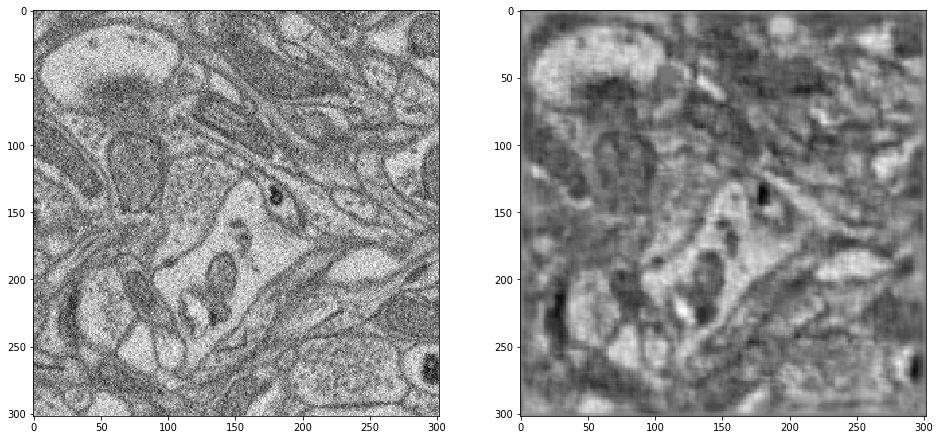

In [26]:
# Show input vs output
data2fig_subplot(inputs, outputs, 3);

(array([   96.,  1316.,  9558., 22060., 21283., 14563., 10058.,  9123.,
         2928.,   219.]),
 array([-1.7843357 , -1.3438909 , -0.90344596, -0.46300107, -0.02255619,
         0.4178887 ,  0.8583336 ,  1.2987785 ,  1.7392234 ,  2.1796682 ,
         2.6201131 ], dtype=float32),
 <a list of 10 Patch objects>)

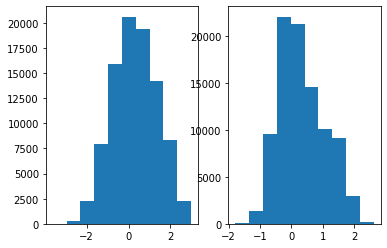

In [22]:
fig, axs = plt.subplots(1,2)
axs[0].hist(inputs[0].data.numpy().flatten())
axs[1].hist(outputs[0].data.numpy().flatten())

In [23]:
30 % 30

0